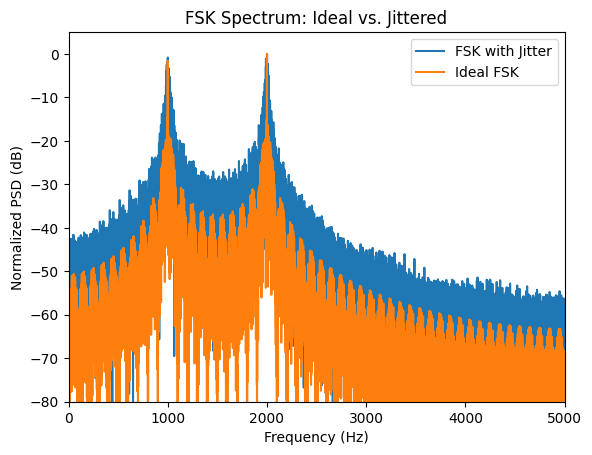

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Simulation parameters
fs = 10000           # Sampling rate (Hz)
T = 0.01             # Bit duration (s)
Nbits = 500          # Number of bits
f0, f1 = 1000, 2000  # FSK tones for bit 0 and 1 (Hz)
sigma_j = 0.0005     # Timing jitter standard deviation (s)

# Generate random bit sequence
bits = np.random.randint(0, 2, size=Nbits)

# Time vector
dt = 1 / fs
total_time = Nbits * T
t = np.arange(0, total_time, dt)

# Function to generate FSK signal given boundary jitters
def generate_fsk(bits, boundaries):
    # Determine which bit each sample belongs to
    bit_indices = np.searchsorted(boundaries, t) - 1
    bit_indices = np.clip(bit_indices, 0, len(bits)-1)
    
    # Instantaneous frequency at each sample
    f_t = np.where(bits[bit_indices] == 0, f0, f1)
    
    # Integrate frequency to get phase
    phase = 2 * np.pi * np.cumsum(f_t) * dt
    return np.cos(phase)

# Ideal boundaries (no jitter)
boundaries_ideal = np.arange(0, (Nbits+1)*T, T)
s_ideal = generate_fsk(bits, boundaries_ideal)

# Jittered boundaries
delta = np.zeros(Nbits+1)
delta[1:-1] = np.random.normal(0, sigma_j, Nbits-1)
boundaries_jitter = boundaries_ideal + delta
s_jitter = generate_fsk(bits, boundaries_jitter)

# Compute FFT-based PSD
S_i = np.fft.fft(s_ideal)
S_j = np.fft.fft(s_jitter)
freqs = np.fft.fftfreq(len(t), d=dt)

# Keep only non-negative frequencies
mask = freqs >= 0
freqs = freqs[mask]
P_i = np.abs(S_i[mask])**2
P_j = np.abs(S_j[mask])**2

# Normalize and convert to dB
P_i_db = 10 * np.log10(P_i / np.max(P_i))
P_j_db = 10 * np.log10(P_j / np.max(P_j))

# Plotting
plt.figure()
plt.plot(freqs, P_j_db, label='FSK with Jitter')
plt.plot(freqs, P_i_db, label='Ideal FSK')

plt.xlim(0, fs/2)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Normalized PSD (dB)')
plt.title('FSK Spectrum: Ideal vs. Jittered')
# set the y-axis limits to -60 dB to -20 dB
plt.ylim(-80, 5)
plt.legend()
plt.show()


In [12]:
import numpy as np

def decode_manchester_oversampled(x, samples_per_bit=16, jitter_tolerance=4):
    """
    Decode Manchester-encoded bits from an oversampled stream with clock jitter.

    Parameters:
    -----------
    x : array-like
        1D array of oversampled Manchester-coded values (floats or ints).
        Values > 0.5 are treated as '1', <= 0.5 as '0'.
    samples_per_bit : int
        Number of samples per encoded bit (default 16).
    jitter_tolerance : int
        Search range (in samples) around the half-bit boundary to locate the
        Manchester transition (default 4).

    Returns:
    --------
    decoded_bits : list of int
        The list of decoded bits (0s and 1s). Ambiguous symbols (no clear
        transition) are skipped.
    """
    x = np.asarray(x)
    # Binarize samples
    xbin = (x > 0.5).astype(int)
    N = len(xbin)
    num_bits = N // samples_per_bit
    decoded_bits = []

    for k in range(num_bits):
        s0 = k * samples_per_bit
        s_end = s0 + samples_per_bit

        # Define search window around nominal half-bit
        mid = s0 + samples_per_bit // 2
        w_start = max(s0 + 1, mid - jitter_tolerance)
        w_end   = min(s_end - 1, mid + jitter_tolerance)

        # Compute differences to locate transition
        segment = xbin[w_start-1 : w_end+1]
        diffs = np.abs(np.diff(segment))
        if diffs.size == 0:
            continue
        # Transition index relative to segment
        idx_off = np.argmax(diffs)
        # Absolute transition index
        bidx = w_start + idx_off

        # Split into two halves and take majority
        first_half  = xbin[s0 : bidx]
        second_half = xbin[bidx : s_end]
        if first_half.size == 0 or second_half.size == 0:
            continue
        a = 1 if first_half.mean()  > 0.5 else 0
        b = 1 if second_half.mean() > 0.5 else 0

        # Manchester decode: 10 -> 0, 01 -> 1
        if a == 1 and b == 0:
            decoded_bits.append(0)
        elif a == 0 and b == 1:
            decoded_bits.append(1)
        # else: ambiguous, skip

    return decoded_bits

# Example usage:
if __name__ == "__main__":
    # generate a test pattern
    bits = [0, 1, 1, 0, 1]
    # Manchester encode: 0 -> [1,0], 1 -> [0,1], oversample by 16
    pattern = []
    for bit in bits:
        half = [1,0] if bit == 0 else [0,1]
        pattern.extend([half[0]] * 8 + [half[1]] * 8)
    # Introduce small random jitter by shifting boundaries
    jittered = np.zeros_like(pattern)
    for k in range(len(bits)):
        # shift by -2 to +2 samples
        shift = np.random.randint(-2, 3)
        start = k*16 + shift
        end   = start + 16
        # print the start and end indices
        print(f"Pattern segment {k}: start={start}, end={end}")
        if start < 0 or end > len(pattern):
            print("Skipping segment due to out-of-bounds indices.")
            continue
        # copy the pattern with jitter          
        jittered[start:end] = pattern[k*16:(k+1)*16]
    decoded = decode_manchester_oversampled(jittered)
    print("Original bits:", bits)
    print("Decoded bits: ", decoded)


Pattern segment 0: start=0, end=16
Pattern segment 1: start=17, end=33
Pattern segment 2: start=31, end=47
Pattern segment 3: start=46, end=62
Pattern segment 4: start=65, end=81
Skipping segment due to out-of-bounds indices.
Original bits: [0, 1, 1, 0, 1]
Decoded bits:  [0, 1, 1, 0]
